In [6]:
import networkx as nx
import numpy as np
import torch
from random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim

In [7]:
def create_dataset():
    Gs = list()
    y = list()

    ############## Task 1

    ##################
    for i in range(50):
        n = randint(10,20)
        Gs.append(nx.fast_gnp_random_graph(n,0.2))
        y.append(0)
        n = randint(10,20)
        Gs.append(nx.fast_gnp_random_graph(n,0.4))
        y.append(1)
    ##################

    return Gs, y


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape)


In [8]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, n_class):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, n_class)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, idx):

        ############## Task 2

        ##################
        z0 = self.relu(self.fc1(torch.mm(adj,x_in)))
        z1 = self.relu(self.fc2(torch.mm(adj,z0)))
        x=z1
        ##################

        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(int(torch.max(idx))+1, x.size(1), device=x_in.device)
        out = out.scatter_add_(0, idx, x)

        ##################
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        ##################

        return F.log_softmax(out, dim=1)


In [9]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
batch_size = 8
n_hidden_1 = 16
n_hidden_2 = 32
n_hidden_3 = 32
learning_rate = 0.01

# Generates synthetic dataset
Gs, y = create_dataset()
n_class = np.unique(y).size

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

N_train = len(G_train)
N_test = len(G_test)

# Initializes model and optimizer
model = GNN(1, n_hidden_1, n_hidden_2, n_hidden_3, n_class).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()

    train_loss = 0
    correct = 0
    count = 0
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        idx_batch = list()
        y_batch = list()

        ############## Task 3

        ##################
        adj_batch = [nx.adjacency_matrix(G_train[j])+sp.identity(nx.adjacency_matrix(G_train[j]).shape[0]) for j in range(i,min(i+batch_size,N_train))]
        adj_batch = sp.block_diag(adj_batch)
        adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch)

        features_batch = torch.ones(adj_batch.shape[0], 1)

        idx_batch = []
        for j in range(i,min(i+batch_size,N_train)):
            for k in range(G_train[j].number_of_nodes()):
                idx_batch.append(j-i)
        idx_batch = torch.LongTensor(idx_batch)
        y_batch = torch.LongTensor([y_train[j] for j in range(i,min(i+batch_size,N_train))])
        ##################

        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))

print('Optimization finished!')

# Evaluates the model
model.eval()
test_loss = 0
correct = 0
count = 0
for i in range(0, N_test, batch_size):
    adj_batch = list()
    idx_batch = list()
    y_batch = list()

    ############## Task 3

    ##################
    adj_batch = [nx.adjacency_matrix(G_test[j])+sp.identity(nx.adjacency_matrix(G_test[j]).shape[0]) for j in range(i,min(i+batch_size,N_test))]
    adj_batch = sp.block_diag(adj_batch)
    adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch)

    features_batch = torch.ones(adj_batch.shape[0], 1)

    idx_batch = []
    for j in range(i,min(i+batch_size,N_test)):
        for k in range(G_test[j].number_of_nodes()):
            idx_batch.append(j-i)
    idx_batch = torch.LongTensor(idx_batch)
    y_batch = torch.LongTensor([y_test[j] for j in range(i,min(i+batch_size,N_test))])
    ##################

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))

Epoch: 0001 loss_train: 8.0417 acc_train: 0.5444 time: 0.3906s
Epoch: 0011 loss_train: 0.2535 acc_train: 0.8889 time: 0.1569s
Epoch: 0021 loss_train: 0.2776 acc_train: 0.8778 time: 0.1582s
Epoch: 0031 loss_train: 0.1728 acc_train: 0.9333 time: 0.1542s
Epoch: 0041 loss_train: 0.1515 acc_train: 0.9444 time: 0.1738s
Epoch: 0051 loss_train: 0.1210 acc_train: 0.9444 time: 0.1549s
Epoch: 0061 loss_train: 0.1534 acc_train: 0.9333 time: 0.1614s
Epoch: 0071 loss_train: 0.1411 acc_train: 0.9444 time: 0.2245s
Epoch: 0081 loss_train: 0.0802 acc_train: 0.9556 time: 0.1739s
Epoch: 0091 loss_train: 0.0651 acc_train: 0.9667 time: 0.1550s
Epoch: 0101 loss_train: 0.0721 acc_train: 0.9556 time: 0.1603s
Epoch: 0111 loss_train: 0.0514 acc_train: 0.9667 time: 0.1580s
Epoch: 0121 loss_train: 0.0559 acc_train: 0.9778 time: 0.1632s
Epoch: 0131 loss_train: 0.0637 acc_train: 0.9667 time: 0.1615s
Epoch: 0141 loss_train: 0.0565 acc_train: 0.9778 time: 0.1537s
Epoch: 0151 loss_train: 0.0528 acc_train: 0.9778 time: 

In [10]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
hidden_dim = 32
output_dim = 4
dropout = 0.0
neighbor_aggr = 'mean'
readout = 'mean'


############## Task 4

##################
list_G = [nx.cycle_graph(n) for n in range(10, 20)]
##################

In [11]:

############## Task 5

##################
adj = [nx.adjacency_matrix(G)+sp.identity(nx.adjacency_matrix(G).shape[0]) for G in list_G]
adj = sp.block_diag(adj)
adj = sparse_mx_to_torch_sparse_tensor(adj)

features = torch.ones(adj.shape[0], 1)

idx_list = []
for idx, G in enumerate(list_G):
    for i in range(nx.adjacency_matrix(G).shape[0]):
        idx_list.append(idx)
idx_list = torch.LongTensor(idx_list)

##################


In [12]:
class MessagePassing(nn.Module):
    def __init__(self, input_dim, output_dim, neighbor_aggr):
        super(MessagePassing, self).__init__()
        self.neighbor_aggr = neighbor_aggr
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc2 = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):

        ############## Task 6

        ##################
        x_node = self.fc1(x)
        m = torch.mm(adj,self.fc2(x))
        ##################

        if self.neighbor_aggr == 'sum':
            output = x_node + m
        elif self.neighbor_aggr == 'mean':
            deg = torch.spmm(adj, torch.ones(x.size(0),1, device=x.device))
            output = x_node + torch.div(m, deg)

        return output



class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, neighbor_aggr, readout, dropout):
        super(GNN, self).__init__()
        self.readout = readout
        self.mp1 = MessagePassing(input_dim, hidden_dim, neighbor_aggr)
        self.mp2 = MessagePassing(hidden_dim, hidden_dim, neighbor_aggr)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj, idx):

        ############## Task 7

        ##################
        x = self.dropout(self.relu(self.mp1(x,adj)))
        x = self.relu(self.mp2(x, adj))
        ##################

        if self.readout == 'sum':
            idx = idx.unsqueeze(1).repeat(1, x.size(1))
            out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            out = out.scatter_add_(0, idx, x)
        elif self.readout == 'mean':
            idx = idx.unsqueeze(1).repeat(1, x.size(1))
            out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            out = out.scatter_add_(0, idx, x)
            count = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            count = count.scatter_add_(0, idx, torch.ones_like(x, device=x.device))
            out = torch.div(out, count)


        ############## Task 7

        ##################
        out = self.fc(out)
        ##################

        return out

In [13]:
############## Task 8

##################
model = GNN(1, hidden_dim, output_dim, 'mean', 'mean', dropout).to(device)
out = model(features, adj, idx_list)
print("neighbor_aggr: mean, readout: mean")
print(out)


model = GNN(1, hidden_dim, output_dim, 'sum', 'sum', dropout).to(device)
out = model(features, adj, idx_list)
print("neighbor_aggr: sum, readout: sum")
print(out)

model = GNN(1, hidden_dim, output_dim, 'sum', 'mean', dropout).to(device)
out = model(features, adj, idx_list)
print("neighbor_aggr: sum, readout: mean")
print(out)


model = GNN(1, hidden_dim, output_dim, 'mean', 'sum', dropout).to(device)
out = model(features, adj, idx_list)
print("neighbor_aggr: mean, readout: sum")
print(out)

##################

2
1
neighbor_aggr: mean, readout: mean
tensor([[ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145],
        [ 0.0039, -0.5437, -0.0036, -0.2145]], grad_fn=<AddmmBackward0>)
1
neighbor_aggr: sum, readout: sum
tensor([[-15.4981,   7.6375,  -7.6464,   0.9697],
        [-17.0417,   8.3931,  -8.4240,   1.0693],
        [-18.5853,   9.1487,  -9.2015,   1.1690],
        [-20.1288,   9.9043,  -9.9790,   1.2686],
        [-21.6724,  10.6599, -10.7566,   1.3683],
        [-23.2160,  11.4156, -11.5341,   1.4679],
        [-24.7596,  12.1712, -12.3117,   1.5676],
        [-26.3032,  12.9268, -13.0892,   1.6672],
        [-27.8467,  13.6824, -13.8667, 

In [14]:
############## Task 9

##################
G1 = nx.Graph()
G1.add_node(1)
G1.add_node(2)
G1.add_node(3)
G1.add_node(4)
G1.add_node(5)
G1.add_node(6)
G1.add_edge(1,2)
G1.add_edge(2,3)
G1.add_edge(1,3)
G1.add_edge(4,5)
G1.add_edge(5,6)
G1.add_edge(4,6)

G2 = nx.Graph()
G2.add_node(1)
G2.add_node(2)
G2.add_node(3)
G2.add_node(4)
G2.add_node(5)
G2.add_node(6)
G2.add_edge(1,2)
G2.add_edge(2,3)
G2.add_edge(3,4)
G2.add_edge(4,5)
G2.add_edge(5,6)
G2.add_edge(6,1)
##################

In [15]:
############## Task 10

##################
list_G = [G1, G2]
adj = [nx.adjacency_matrix(G)+sp.identity(nx.adjacency_matrix(G).shape[0]) for G in list_G]
adj = sp.block_diag(adj)
adj = sparse_mx_to_torch_sparse_tensor(adj)

features = torch.ones(adj.shape[0], 1)

idx_list = []
for idx, G in enumerate(list_G):
    for i in range(nx.adjacency_matrix(G).shape[0]):
        idx_list.append(idx)
idx_list = torch.LongTensor(idx_list)
##################


In [16]:
############## Task 11

##################
model = GNN(1, hidden_dim, output_dim, neighbor_aggr="sum", readout="sum", dropout=dropout).to(device)
out = model(features, adj, idx_list)
print(out)
##################

1
tensor([[ -5.4725, -12.4048,  -6.8671,  10.9450],
        [ -5.4725, -12.4048,  -6.8671,  10.9450]], grad_fn=<AddmmBackward0>)


In [25]:
############## Q4

##################
G1 = nx.Graph()
G1.add_node(1)
G1.add_node(2)
G1.add_node(3)
G1.add_node(4)
G1.add_edge(1,2)
G1.add_edge(3,4)

G2 = nx.Graph()
G2.add_node(1)
G2.add_node(2)
G2.add_node(3)
G2.add_node(4)
G2.add_edge(1,2)
G2.add_edge(2,3)
G2.add_edge(3,4)
G2.add_edge(4,1)


G1 = nx.Graph()
G1.add_node(1)
G1.add_node(2)
G1.add_node(3)
G1.add_node(4)
G1.add_node(5)
G1.add_node(6)
G1.add_edge(1,2)
G1.add_edge(2,3)
G1.add_edge(1,3)
G1.add_edge(4,5)
G1.add_edge(5,6)
G1.add_edge(6,7)
G1.add_edge(7,4)

G2 = nx.Graph()
G2.add_node(1)
G2.add_node(2)
G2.add_node(3)
G2.add_node(4)
G2.add_node(5)
G2.add_node(6)
G2.add_edge(1,2)
G2.add_edge(2,3)
G2.add_edge(3,4)
G2.add_edge(4,5)
G2.add_edge(5,6)
G2.add_edge(6,7)
G2.add_edge(7,1)

list_G = [G1, G2]
adj = [nx.adjacency_matrix(G)+sp.identity(nx.adjacency_matrix(G).shape[0]) for G in list_G]
adj = sp.block_diag(adj)
adj = sparse_mx_to_torch_sparse_tensor(adj)

features = torch.ones(adj.shape[0], 1)

idx_list = []
for idx, G in enumerate(list_G):
    for i in range(nx.adjacency_matrix(G).shape[0]):
        idx_list.append(idx)
idx_list = torch.LongTensor(idx_list)


model = GNN(1, hidden_dim, output_dim, neighbor_aggr="sum", readout="sum", dropout=dropout).to(device)
out = model(features, adj, idx_list)
print(out)
##################

1
tensor([[-4.9904,  8.8797,  0.2486,  4.0121],
        [-4.9904,  8.8797,  0.2486,  4.0121]], grad_fn=<AddmmBackward0>)


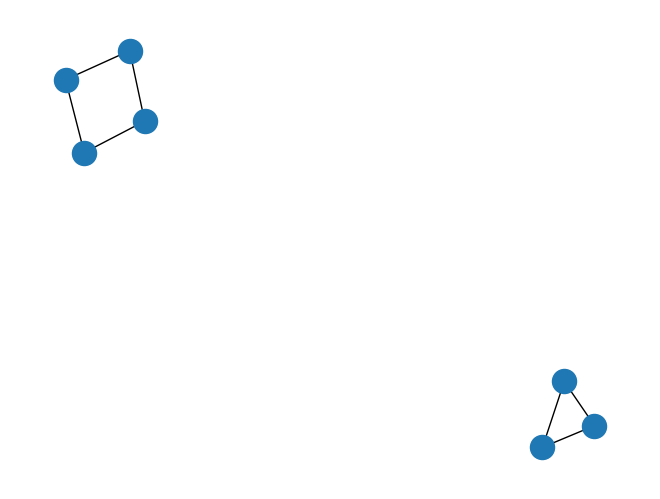

In [29]:
nx.draw(G1)

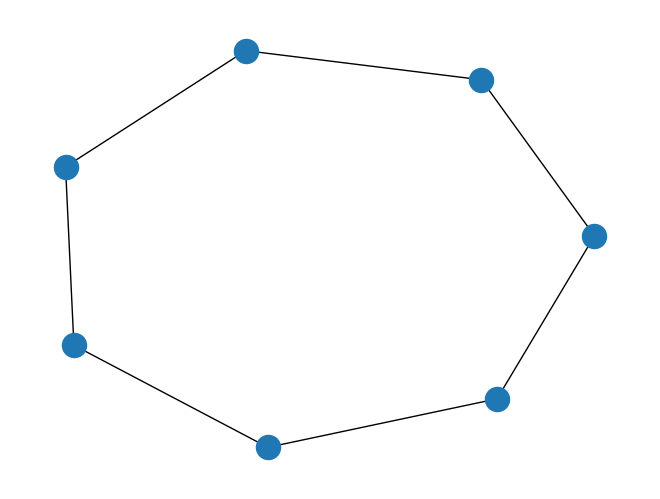

In [30]:
nx.draw(G2)